**Name**: San Sit, Hoyun Jung, Natalie Krahn, Juliana Meneghetti
<h3> Introduction </h3>

<h4> (1) Background Information </h4>

In recent years, Minecraft has remained one of the most popular video games, attracting millions of players worldwide. As a sandbox game that allows users to explore, build, and interact in a virtual world, Minecraft appeals to a wide demographic, from casual beginners to dedicated professionals.

This project is part of an ongoing research based on the dataset led by **Frank Wood's Computer Science research group at UBC**, which is studying how people play video games. Their team has set up a dedicated Minecraft server, where players' actions are recorded as they navigate through the world. *(Harvey et al., 2022)*

By applying a K-Nearest Neighbors (KNN) classification model, we analyze the relationship between a player's engagement metrics (age and played hours) and their likelihood of subscribing. The dataset is preprocessed to convert categorical variables into factors, scale numerical values, and split into training and testing subsets. The model is then fine-tuned using cross-validation to determine the optimal number of neighbors (K) before making predictions on new data.

This study provides insights into the characteristics of subscribed players and explores whether playtime and age can serve as reliable indicators of subscription likelihood.


<h4> (2) Questions </h4>

**My broad question** - Question 1: Player characteristics and behaviors most predictive of subscribing to a game-related newsletter. <br>
**Specific** - "Can player experience level, total playtime, and age predict whether a player will subscribe to a game-related newsletter?"


<h4> (3) Data Description </h4>

Our given data is recording players' actions within Minecraft (Woods, 2022) . Our project will analyze the dataset players and their characteristics.

In *players*, there are 196 observations with 7 variables: (Dataset taken from *Harvey et al., 2022*)
- `experience` (character): the level of expertise the player has within Minecraft separated (best to worst): Beginner, Regular, Amateur, Pro, and Veteran
- `subscribed`(boolean): whether the player is subscribed to newsletter (TRUE) or not (FALSE)
- `hashedEmail`(character): player's encrypted and anonymized email (used for identification)
- `played_hours`(double): the amount of hours played by player
- `name`(character): name of the player
- `gender` (character): player's gender
- `Age`(double): player's age <br>

In [1]:
library(tidyverse)
library(scales)
library(dplyr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    

In [2]:
set.seed(123)
# Importing players.csv and sessions.csv from my github list I uploaded to
# NOTE: sessions is imported solely for demonstration of the players and session data frames being able to be loaded into R
players <- read_csv("https://raw.githubusercontent.com/SansIt/ds-project/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/SansIt/ds-project/refs/heads/main/sessions.csv")

# Only players are needed for my analysis
head(players)
players_split <- initial_split(players, prop = 0.8, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


The data seem tidy: each row - single observation, each column - single variable, and each value - single cell. 
Possible datatype improvements:

In [3]:
# Experience to factor (for comparisons later)
# Age to integer (as right now it is in double and a decimal age does not really help or make a difference in demographics)
# Let us also fix the capitalization of age as it is the only column/ variable whose first term is capitalized
players_fixed <- players_training |>
                mutate(experience = as_factor(experience)) |>
                mutate(age = as.integer(Age)) |>
                select(-Age)

In [4]:
# To compute the mean of each quantitative variable, there are only 2 (hours played and age):
players_mean <- players_fixed |>
            summarize(mean_age = mean(age, na.rm = TRUE), mean_played_hours = mean(played_hours)) 
players_mean

mean_age,mean_played_hours
<dbl>,<dbl>
20.90909,6.875641


For visualization, I choose the main target variable as boolean `subscribed` versus:
- `age` and `played_hours` as histograms (distribution of quantitative)
- `experience` level as a bar chart (comparison of category amounts)

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 67 rows containing non-finite outside the scale range (`stat_bin()`).”


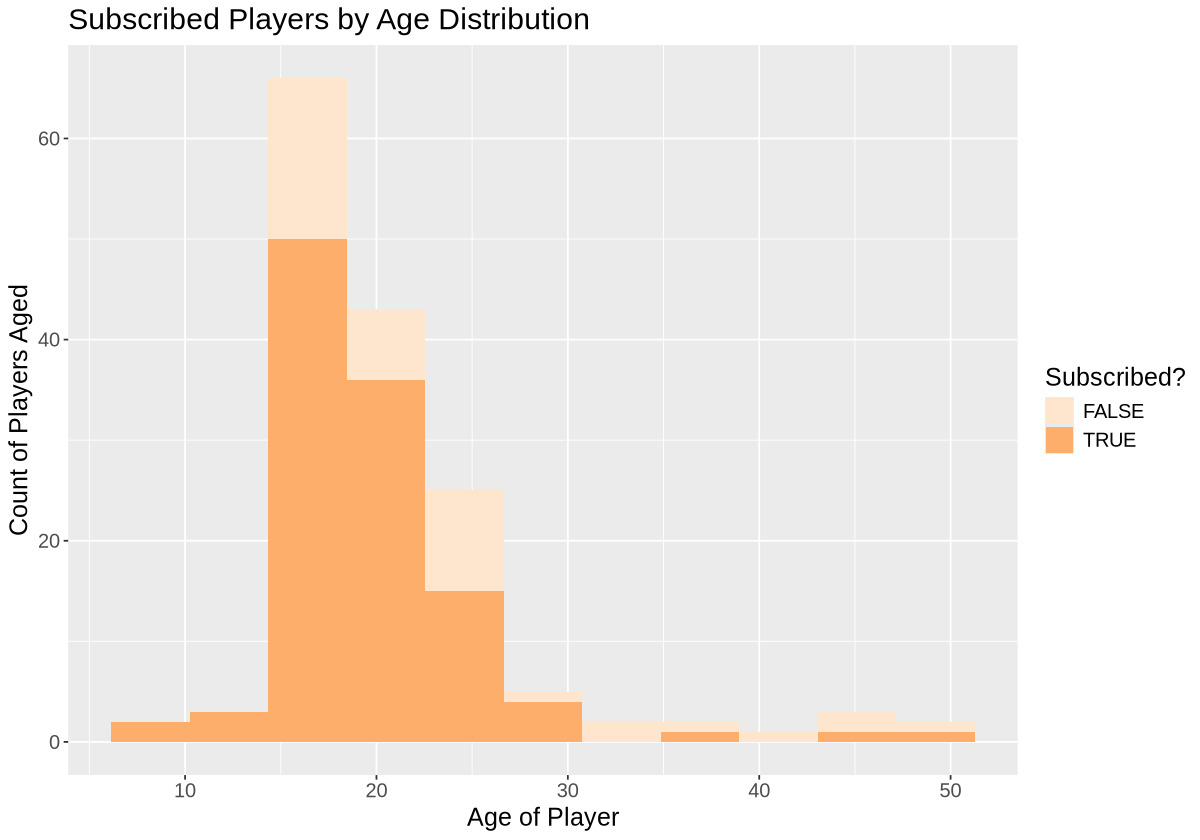

`summarise()` has grouped output by 'subscribe'. You can override using the
`.groups` argument.


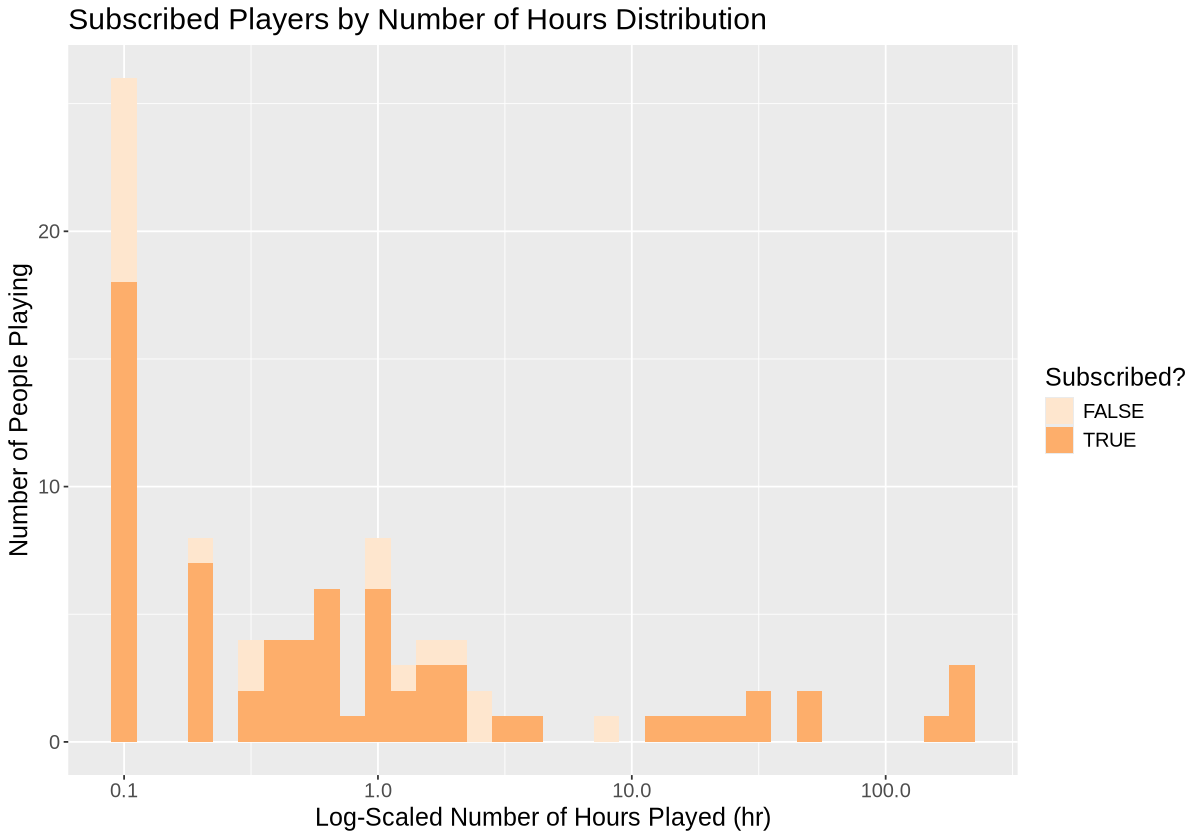

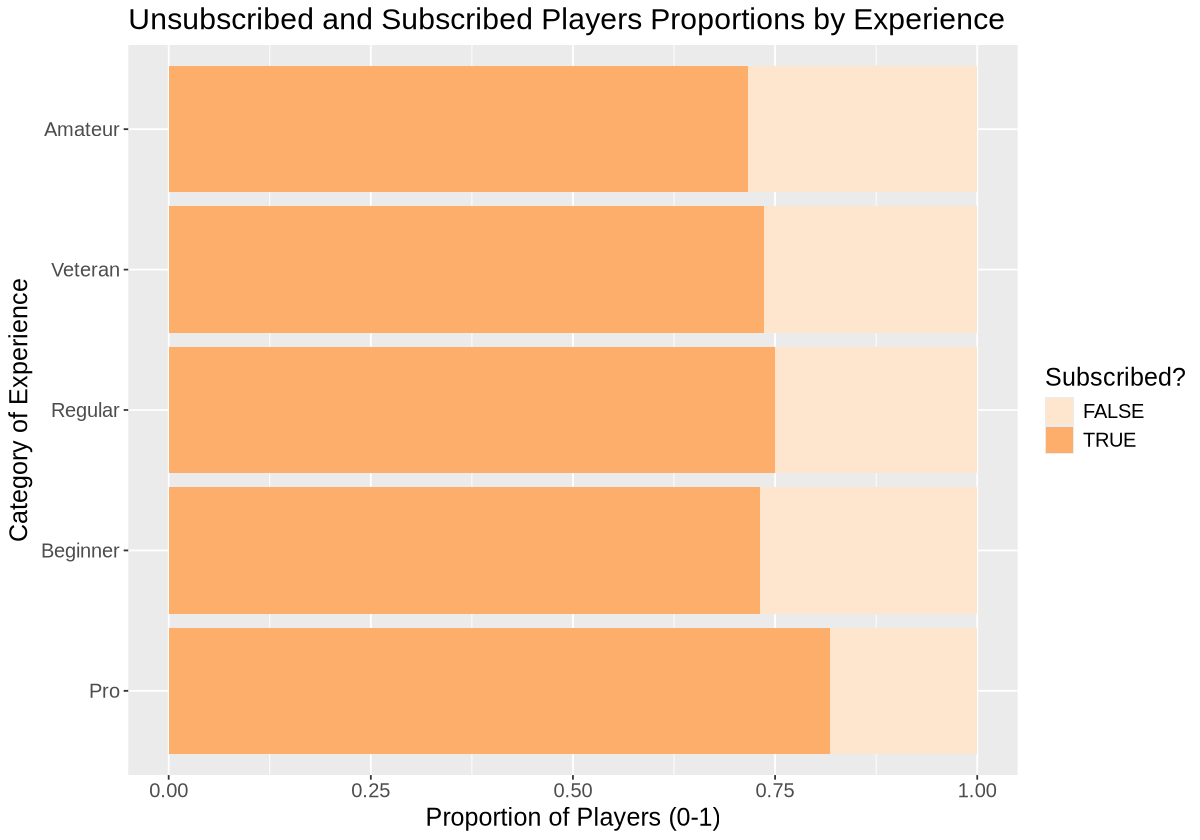

In [5]:
options(repr.plot.width = 10, repr.plot.height = 7)
# For the quantitative variables
# Ensuring they are colour-blind friendly
# Histograms are the best visualization in distributing quantitative data and filling by subscribed or not
age_plot <- players_fixed |>
                    ggplot(aes (x = age, fill = subscribe)) +
                    geom_histogram(bins = 11) +
                    labs(x = "Age of Player", y = "Count of Players Aged", fill = "Subscribed?") +
                    ggtitle("Subscribed Players by Age Distribution") +
                    theme(text = element_text(size = 15)) +
                    scale_fill_brewer(palette = "Oranges")

# Scaled x-axis as one group of played hours heavily skewed the bar graph till the others were not visible
hours_plot <- players_fixed |>
                    ggplot(aes (x = played_hours, fill = subscribe)) +
                    geom_histogram(binwidth = 0.1) +
                    labs(x = "Log-Scaled Number of Hours Played (hr)", y = "Number of People Playing", fill = "Subscribed?") +
                    ggtitle("Subscribed Players by Number of Hours Distribution") +
                    scale_x_log10(labels = label_comma()) + 
                    theme(text = element_text(size = 15)) +
                    scale_fill_brewer(palette = "Oranges")

age_plot
hours_plot

# For categorical amounts, make a new summarized count for true and false
# Bar graphs are most effective for comparing amounts (in this case, by Experience)
# We use position = "fill" because we are interested in the proportion of how much each category of experience subscribes
players_experience <- players_fixed |>
                group_by(subscribe, experience) |>
                summarize(count = n())
players_experience_plot <- players_experience |>
                    ggplot(aes (x = count, y = fct_reorder(experience, count), fill = subscribe)) +
                    geom_bar(stat = "identity", position = "fill") +
                    labs(x = "Proportion of Players (0-1)", y = "Category of Experience", fill = "Subscribed?") +
                    ggtitle("Unsubscribed and Subscribed Players Proportions by Experience") +
                    theme(text = element_text(size = 15)) + 
                    scale_fill_brewer(palette = "Oranges")

players_experience_plot 


#### Graph Analysis:
- `age`: Younger players are more likely to subscribe, with most subscribers in their late teens to early twenties (Elders do not).
- `played_hours`: Subscription status varies across playtime levels but is guaranteed for moderate-to-high playtime.
- `Experience`: Experience shows a trend where *Regular* and *Beginner* players subscribe notably most. <br>
`Age` and `Experience` seem strong predictors, while `played_hours` is decent but requires further analysis/ standardization.


### (4) Methods and Plans
I propose using **k-Nearest Neighbors (k-NN)** classification because it's the most intuitive for categorical prediction problems and identifying patterns using both numerical and categorical data.

**My predictor variables**:
- `age` (Quantitative)
- `played_hours` (Quantitative)

*Note*: We chose to exclude `Experience` as it is categorical and k-NN requires either only categorical or only numerical (we chose numerical predictors).

#### Assumptions Required
- Since k-NN relies on distance, we assume our dataset is unstandardized and have to normalize numerical quantities.
- Dataset should not skew toward a majority range, but early data suggests overrepresentation in specific `age` and `played_hours` ranges.

#### Weaknesses
- The `age` variable is slightly imbalanced, with a dominant 0-25 range, which may bias predictions based on the range's trends.
- `played_hours` has the same problem with a range 0-10 hours played.
- Too many predictor variables can make k-NN less effective if some chosen predictors are less reliable.

#### Processing, Comparing, Selecting
- Preprocessing includes standardization and handling missing values (NA).
- To ensure reliable model fitting,:
  1. Split the data into training and testing, with an 80-20% split, stratifying by `subscribe`.
  2. Use 7-fold cross-validation to determine the best number of neighbours and train the model on both sets.
  3. Evaluate our model on the testing data and collect metrics.

Prioritizing **high accuracy** is the key, as the newsletter would benefit more from identifying which characteristics generally subscribe more correctly (for more effective marketing campaigns) rather than maximizing subscriber identification (recall).


In [6]:
library(tidymodels)

After loading the dataset, we mutate the subscribe variable to a factor so we can treat “subscribe” as a categorical variable. Then we split the dataset into a training dataset (80% of the data) and a testing dataset (20% of the data) where the strata—variable used to do the sampling—is “subscribe”. In order to make this data reproducible, we will set the seed so that the k value doesn't change each time we run the code.

In [8]:
players_recipe <- recipe(subscribe ~ age + played_hours, data = players_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

After this split, we create a recipe with the training dataset using subscribe as the predictor variable and age + played hours as the explanatory variables. We make sure we scale all predictors so that no variable has more effect on the outcome. Next, we use the K-NN model where weight_func = “rectangular” gives us equal weight for all neighbours, and we tune for the best number of neighbours. Then we specify we are using the kknn package and are performing a classification. 

In [9]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

players_vfold <- vfold_cv(players_training, v = 7, strata = subscribe)

knn_results <- workflow() |>
               add_model(knn_spec) |>
               add_recipe(players_recipe) |>
               tune_grid(resamples = players_vfold, grid = k_vals) |>
               collect_metrics()

best_k <- knn_results |>
        filter(.metric == "accuracy") |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 17 rows.
               ✖ Assigned data has 18 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 18 to size 17.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 16 rows.
               ✖ Assigned data has 17 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 17 to size 16.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

There were issues with some computations   A: x1   B: x1





[1] 11

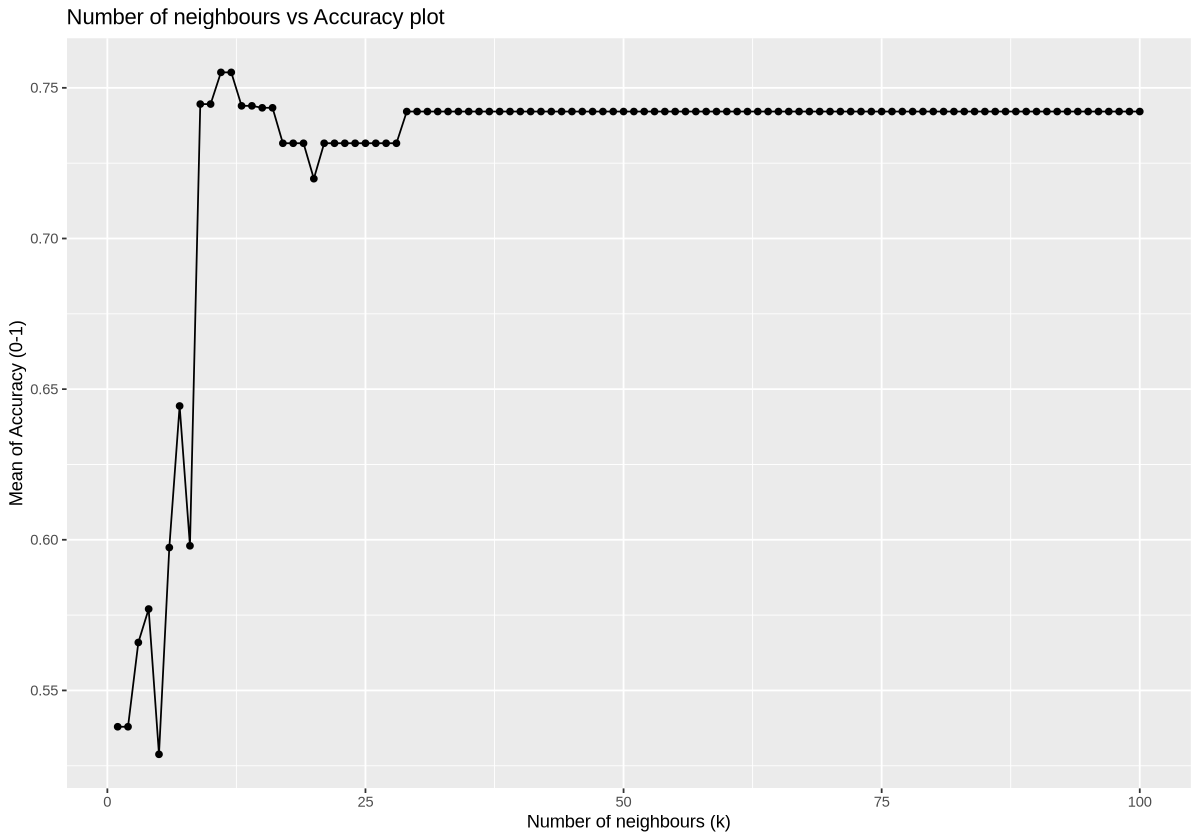

In [10]:
accuracy <- knn_results |>
            filter(.metric == "accuracy") 

k_graph <- accuracy|>
            ggplot(aes (x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            labs(x = "Number of neighbours (k)", y = "Mean of Accuracy (0-1)") +
            ggtitle("Number of neighbours vs Accuracy plot")

k_graph

Next we create a tibble with neighbours that range from 1 to 120 and increase by an increment of 1. We then want to perform a cross validation, where we have chosen 7-fold on the training dataset. Next we are building a workflow using the model and recipe we created above and tuning it using the 7-fold cross validation and k values in the tibble and finding the accuracy of this assessment.  Then, find the best k value by sorting the accuracies and pulling the best k based on its accuracy. This gives us a value of $11$ as our best k-value. 

In [11]:
knn_spec_best_k <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_fit <- workflow() |>
               add_model(knn_spec_best_k) |>
               add_recipe(players_recipe) |>
               fit(players_training)

players_test_predictions <- predict(knn_fit, players_testing) |>
  bind_cols(players_testing)

accuracy <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")


players_test_predictions
accuracy

.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<fct>,<fct>,<chr>,<dbl>,<chr>,<chr>,<int>
TRUE,Amateur,FALSE,2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53,0.0,Quinlan,Male,22
TRUE,Amateur,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,Female,17
TRUE,Beginner,FALSE,fa7d496b2f74c51ec70395bd8397b49f97a3ce8d7ba7e08887d82ec0008137a7,0.0,Umar,Male,24
TRUE,Amateur,FALSE,9253d1969af1ff941ac9b2a4b2c61158932898827ac710d5bf156a0e6a06742b,0.0,Ziad,Two-Spirited,23
TRUE,Amateur,FALSE,43768b39e3386b287e3c5598f0b18a27b84126ca92ea1b62f30b29c0cae2229e,0.0,Zayn,Prefer not to say,17
TRUE,Regular,FALSE,63139b524e44d156daf265875fb8078bb2b24d6b7520a35eda58c2d97bb8d15c,0.0,Elias,Male,23
TRUE,Beginner,FALSE,722ab6d91280c439f2780767a1250889e93f75fc0ba0bc48175da022ab3e9ea9,0.0,Leyla,Female,17
TRUE,Beginner,FALSE,e74c60a92c0100e7240be56d66969db85856152b048c639331a3595f901461ae,7.1,Arash,Male,17
FALSE,Amateur,FALSE,6fa105fac7f4f37350f21830db78cde153d8edda41d6f4f2d48c9785d605c5e5,0.1,Yosef,Male,45


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


After, we do the same K-NN model, but this time with the neighbours = 22 (our best k-value) and create a workflow with this new nearest_neighbor spec with the best k (still using training dataset). Next, we can predict the classes for each value in the testing dataset, producing a tibble with .pred_class and binding these columns with our original testing dataset for comparison. After, we calculate the accuracy of this model which gives us 0.725. Next, we want to understand these results better by creating a visualization.

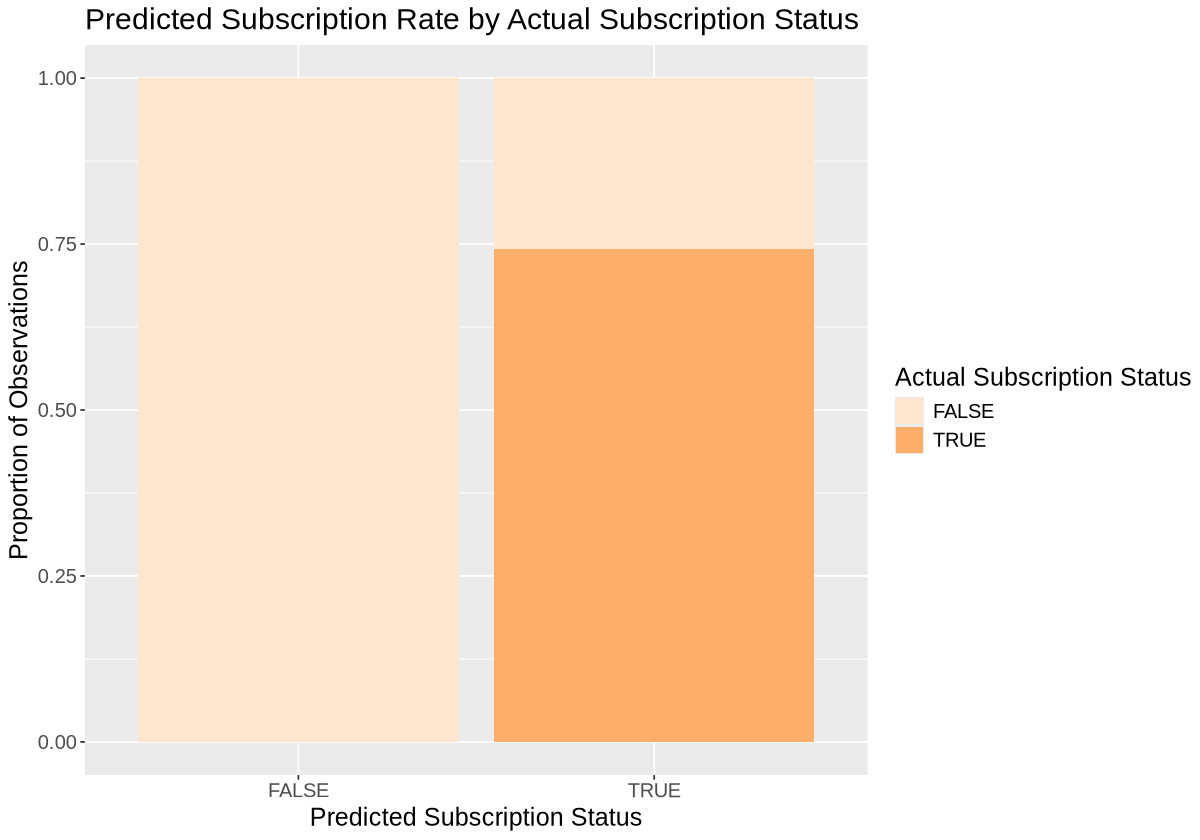

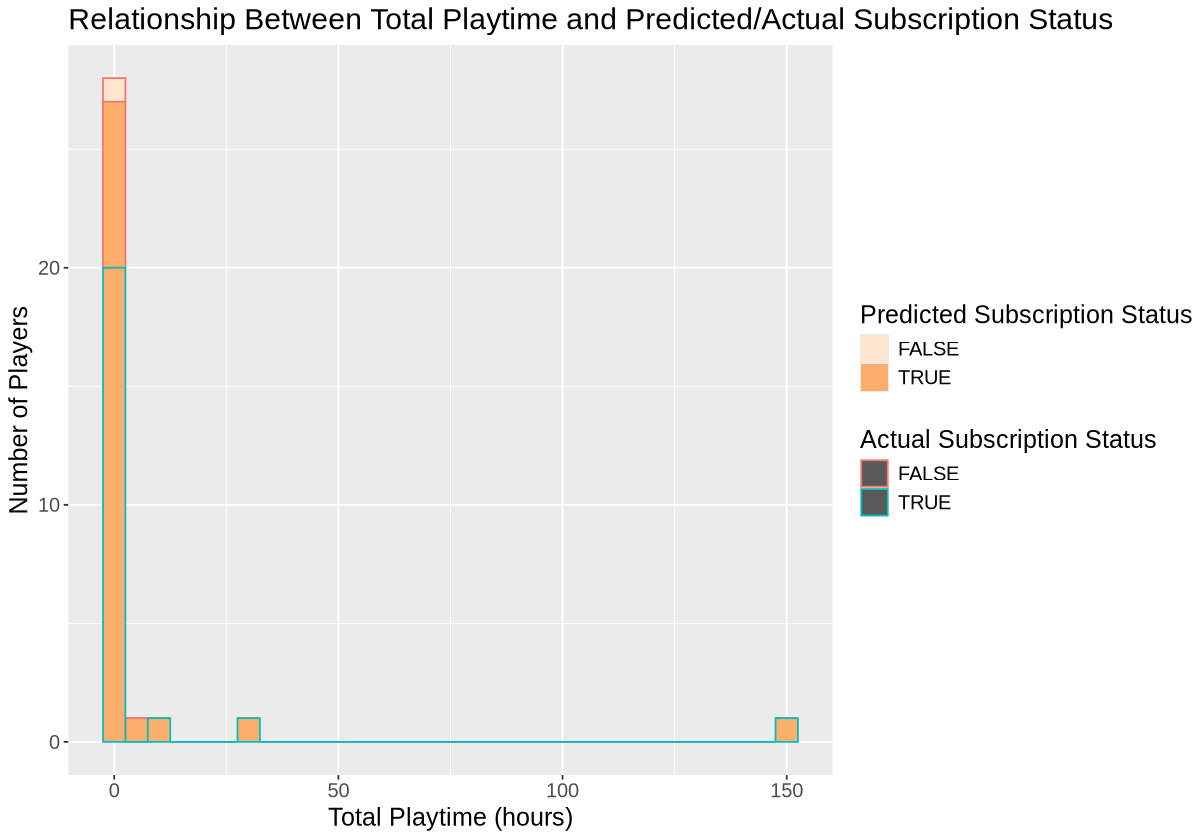

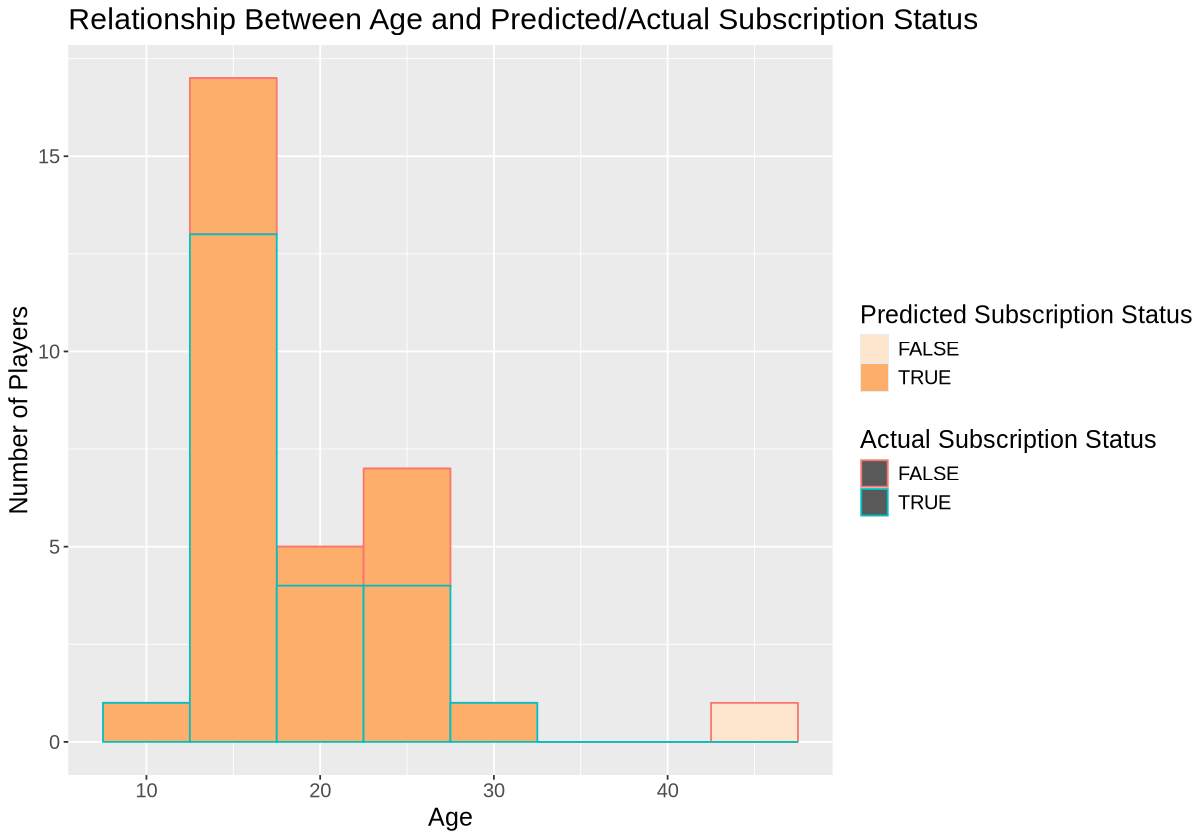

In [12]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Bar plot of subscription prediction by predicted class
bar_plot_pred <- players_test_predictions |>
  ggplot(aes(x = .pred_class, fill = factor(subscribe))) +
  geom_bar(position = "fill") + 
  labs(
    title = "Predicted Subscription Rate by Actual Subscription Status",
    x = "Predicted Subscription Status",
    y = "Proportion of Observations",
    fill = "Actual Subscription Status"
  ) +
    theme(text = element_text(size = 15)) + 
  scale_fill_brewer(palette = "Oranges")
 bar_plot_pred

# Histogram of relationship between total playtime and predicted subscription status compared to actual subscription status
players_playtime_pred_plot <- players_test_predictions |>
  ggplot(aes(x = played_hours, fill = .pred_class, color = factor(subscribe))) +
  geom_histogram(binwidth = 5) +
  labs(
    title = "Relationship Between Total Playtime and Predicted/Actual Subscription Status",
    x = "Total Playtime (hours)",
    y = "Number of Players",
    fill = "Predicted Subscription Status",
    color = "Actual Subscription Status"
  ) +
    theme(text = element_text(size = 15)) + 
  scale_fill_brewer(palette = "Oranges")

players_playtime_pred_plot


# Histogram of relationship between age and predicted subscription status compared to actual subscription status
players_age_pred_plot <- players_test_predictions |>
  ggplot(aes(x = age, fill = .pred_class, color = factor(subscribe))) +
  geom_histogram(binwidth = 5) +
  labs(
    title = "Relationship Between Age and Predicted/Actual Subscription Status",
    x = "Age",
    y = "Number of Players",
    fill = "Predicted Subscription Status",
    color = "Actual Subscription Status"
  ) +
    theme(text = element_text(size = 15)) + 
  scale_fill_brewer(palette = "Oranges")

players_age_pred_plot

We are going to create **3 different visualizations** to best understand this dataset: 
1. The first will be a bar plot of predictions of `subscribe` based on prediction class `.pred_class`. We take the test predictions data and plot it with the predicted class on the x-axis and the subscription status `subscribe` as the fill colour. We then give the plot proper labels and change the text size and colour palette to make it easier to read.
2. Next, we are going to create a histogram of the relationship between `total_playtime` and predicted subscription status `.pred_class` compared to actual subscription status `subcribe`. We again take the test predictions data and plot it with the played hours as the x-axis, predicted class as the fill colour, and the outline colour based on subscription status. We then give the plot proper labels and change the text size and colour palette to make it easier to read.
3.  Finally, we create a histogram of the relationship between `age` and predicted subscription status `.pred_class` compared to actual subscription status `subscribe`. We will take the predictions data and plot it with the player `age` on the x-axis, predicted class `.pred_class` as the fill colour, and the outline colour based on subscription status `subscribe`. We then make sure proper labels are given and the text size and colour palette make the plot easier to read. 

<h3> Discussion </h3>

Plot 1:
This plot evaluates how well the model is predicting the subscription class, highlighting the proportion of true positives and false positives. Since our model prioritizes high precision, we want a more accurate model than one that maximizes recall. Our model has a precision of 0.725 which is good for our uses of predicting subscription status of each player. 


Plot 2:
This plot evaluates how total playtime affects subscription status. Since most players have pretty low total playtime, the plot more correctly identifies true positives at higher total playtime, with a higher percentage of false positives at lower total playtime. 


Plot 3:
This plot evaluates how player age affects subscription status. It seems that players younger than 20 years old dominate the dataset and this group is more likely to subscribe to a newsletter than the older age groups. The model shows a pretty high accuracy which is helpful in predicting the subscription status of each player based on age. 


The results for total playtime was not expected. Before analysis, it seemed more likely that players with higher total playtime would subscribe to a game-related newsletter, but the results show that players with lower total playtime are actually more likely to subscribe. The results for age was expected, as it seemed more likely that younger players would subscribe to a game-related newsletter. In fact, the data shows this and becomes very helpful in future promotional efforts for game-related newsletters. These findings would allow video game companies to target demographics where their efforts are more likely to be successful. This data could also be helpful in further researching the demographics that are less likely to subscribe to game-related newsletters and discover what tools or methods could be used to encourage, promote, and attract more users to play video games and subscribe to newsletters. 

<h3> References </h3>



- Harvey, W., Naderiparizi, S., Masrani, V., Weilbach, C., & Wood, F. (2022). Flexible Diffusion Modeling of Long Videos (No. arXiv:2205.11495). arXiv.
    https://doi.org/10.48550/arXiv.2205.11495
- Timbers, T., Campbell, T., & Lee, M. (2024, August 21). Data Science: A First Introduction. Data Science. https://datasciencebook.ca/ 
